данные взяты самостоятельно, так что их загрузка возможна только через импорт папки projects в корневую папку своего гугл диска

In [1]:
#@title импорт библиотек 
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from keras.models import model_from_json
from keras.models import load_model
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten,Conv1D,MaxPooling1D,Dropout,BatchNormalization,Embedding,Input,Concatenate,GlobalMaxPooling1D,Reshape
from keras.models import Model
from keras.layers import Dropout
from tensorflow.python.client import device_lib
import os
from keras.models import Sequential, Model
import plotly.graph_objects as go
from keras.layers import *

In [ ]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))
strategy = tf.distribute.TPUStrategy(resolver)

In [3]:
#@title импорт данных

testCots = []
lastCots = []
trainCots = []
drive.mount('/content/drive', force_remount=True)

#парсинг тренировочного набора
e=np.load("/content/drive/MyDrive/projects/P1/eee.npy")
cots = open('/content/drive/MyDrive/projects/P1/lerP.csv')
for i in cots.read().split('\n'):
    trainCots += [[float(f) for f in i.split(';')]]
for i in range(len(trainCots)):
    trainCots[i]+=[e[i]]

#парсинг тестового набора 
cots = open('/content/drive/MyDrive/projects/P1/testP.csv')
for i in cots.read().split('\n'):
    testCots += [[float(f) for f in i.split(';')]+[1]]

cots = open('/content/drive/MyDrive/projects/P1/lastTest.csv')
for i in cots.read().split('\n'):
    lastCots += [[float(f) for f in i.split(';')]+[1]]


Mounted at /content/drive


In [2]:
#@title генератор v1
def Generator(batchsize, col, cots, pref=False, gen=False, noNon=False, Dler=False,mstart=-1,dlerd=0.12):
    genin = []
    while True:
        inputs = []
        targets = []
        for i in range(0, batchsize):
            inp = []
            # случайный выбор точки в выборке
            if mstart == -1:
                if random.random() < dlerd and Dler:
                    while True:
                        start = random.randint(0, len(cots)-1100)
                        if cots[start][8] <= 1.0:
                            targets.append([0.0, 1.0, 0.0])
                            break
                else:
                    while True:
                        start = random.randint(0, len(cots)-1100)
                        if cots[start][8] > 1.5 or not pref:
                                if (float(cots[start+col-1][6]) > 0 or float(cots[start+col-1][7]) > 0 or not noNon):
                                    if float(cots[start+col-1][6]) > 0:
                                        targets.append([1.0, 0.0, 0.0])
                                    elif float(cots[start+col-1][7]) > 0:
                                        targets.append([0.0, 0.0, 1.0])
                                    else:
                                        targets.append([0.0, 1.0, 0.0])
                                    break
            else:
                start=mstart
            genin += [start]

            m = np.array(cots[start:start+col]).transpose()
            higmax = max(m[1])
            lowmin = min(m[2])
            volmax = max(m[5])
            volmin = min(m[5])
            inp.append(cots[start][4])
            inp.append(higmax/lowmin)
            for k in range(start, start+col):
                inp.append((cots[k][0]-lowmin)/(higmax-lowmin))
                inp.append((cots[k][1]-lowmin)/(higmax-lowmin))
                inp.append((cots[k][2] - lowmin)/(higmax-lowmin))
                inp.append((cots[k][3]-lowmin)/(higmax-lowmin))
                inp.append((cots[k][5]-volmin)/(volmax-volmin))
            inputs.append(inp)
        if gen:
            yield np.array(inputs), np.array(targets), genin
        else:
            yield np.array(inputs), np.array(targets)

In [ ]:
#@title отображение одного примера
A=next(Generator(1,100,lastCots))
A=A[0][0]
fig = go.Figure(data=go.Ohlc(open=A[1::5],high=A[3::5],low=A[4::5],close=A[5::5]))
fig.show()

In [ ]:
#@title модель

def replace(repa,F,num,rep):
    d=tf.math.not_equal(F,num)
    len=F.shape[0]
    return tf.where(tf.stack([d]*3,1) ,repa,tf.reshape(rep,[1,3]))

def replacea(repa,F,num,rep):
    d=tf.math.not_equal(F,num)
    len=F.shape[0]
    return tf.where(d ,repa,rep)

def auf(P,Y):
    P=tf.argmax(P,axis=1)
    Y=tf.argmax(Y,axis=1)

    P=P+1
    Y=Y+7
    C=P*Y
    
    noty=tf.fill([Y.shape[0], 3], 0.)

    noty = replace(noty,C,7,[1.,0.,0.])
    noty = replace(noty,C,8,[0.,1.,0.])
    noty = replace(noty,C,9,[0.,1.,0.])

    noty = replace(noty,C,14,[1.,0.,0.])
    noty = replace(noty,C,16,[0.,1.,0.])
    noty = replace(noty,C,18,[0.,0.,1.])

    noty = replace(noty,C,21,[0.,1.,0.])
    noty = replace(noty,C,24,[0.,1.,0.])
    noty = replace(noty,C,27,[0.,0.,1.])


    samp=tf.fill([Y.shape[0]], 0.)

    samp = replacea(samp,C,7,[0.5])
    samp = replacea(samp,C,8,[0.41])
    samp = replacea(samp,C,9,[0.3])

    samp = replacea(samp,C,14,[0.50])
    samp = replacea(samp,C,16,[0.40])
    samp = replacea(samp,C,18,[0.50])

    samp = replacea(samp,C,21,[0.3])
    samp = replacea(samp,C,24,[0.41])
    samp = replacea(samp,C,27,[0.5])

    

    return samp,noty

class CustomModel(keras.Model):

    def train_step(self, data):

        sample_weight = None
        (x, y) = data
        
        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)
            sample_weight,y=auf(y_pred,y)
            loss = self.compiled_loss(y, y_pred, sample_weight=sample_weight, regularization_losses=self.losses)

        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        self.compiled_metrics.update_state(y, y_pred, sample_weight=sample_weight)

        return {m.name: m.result() for m in self.metrics}

In [ ]:
#@title создание модели , ввод в десятитысячных
def build():
    
    lrelu=keras.layers.LeakyReLU(alpha=0.3)

    input = Input(shape=(4502,))

    iner=keras.initializers.HeUniform()

    x=Dense(3000, activation=lrelu, kernel_initializer=iner,kernel_regularizer="l2")(input)
    x=BatchNormalization()(x)

    x=Dense(2000, activation=lrelu, kernel_initializer=iner,kernel_regularizer="l2")(x)
    x=BatchNormalization()(x)

    x=Dense(1000, activation=lrelu, kernel_initializer=iner,kernel_regularizer="l2")(x)
    x=BatchNormalization()(x)

    x=Dense(500, activation=lrelu, kernel_initializer=iner,kernel_regularizer="l2")(x)
    x1=BatchNormalization()(x)

    x=Dense(300, activation=lrelu, kernel_initializer=iner,kernel_regularizer="l2")(x1)
    x=BatchNormalization()(x)

    x=Dense(200, activation=lrelu, kernel_initializer=iner,kernel_regularizer="l2")(x)
    x=BatchNormalization()(x)

    
    x=Dense(200, activation=lrelu, kernel_initializer=iner,kernel_regularizer="l2")(x)
    x=BatchNormalization()(x)

    x=Dense(200, activation=lrelu, kernel_initializer=iner,kernel_regularizer="l2")(x)
    x=BatchNormalization()(x)

    ########################################
    x=keras.layers.concatenate([x,x1])
    x=Dense(200, activation=lrelu, kernel_initializer=iner,kernel_regularizer="l2")(x)
    x=BatchNormalization()(x)

    x=Dense(200, activation=lrelu, kernel_initializer=iner,kernel_regularizer="l2")(x)
    x=BatchNormalization()(x)

    x=Dense(200, activation=lrelu, kernel_initializer=iner,kernel_regularizer="l2")(x)
    x=BatchNormalization()(x)

    x=Dense(200, activation=lrelu, kernel_initializer=iner,kernel_regularizer="l2")(x)
    x=BatchNormalization()(x)

    x=Dense(200, activation=lrelu, kernel_initializer=iner,kernel_regularizer="l2")(x)
    x=BatchNormalization()(x)

    x=Dense(200, activation=lrelu, kernel_initializer=iner,kernel_regularizer="l2")(x)
    x=BatchNormalization()(x)

    x=Dense(200, activation=lrelu, kernel_initializer=iner,kernel_regularizer="l2")(x)
    x=BatchNormalization()(x)


    ######################################
    x=keras.layers.concatenate([x,x1])

    x=Dense(200, activation=lrelu, kernel_initializer=iner,kernel_regularizer="l2")(x)
    x=BatchNormalization()(x)

    x=Dense(200, activation=lrelu, kernel_initializer=iner,kernel_regularizer="l2")(x)
    x=BatchNormalization()(x)

    x=Dense(200, activation=lrelu, kernel_initializer=iner,kernel_regularizer="l2")(x)
    x=BatchNormalization()(x)

    x=Dense(200, activation=lrelu, kernel_initializer=iner,kernel_regularizer="l2")(x)
    x=BatchNormalization()(x)

    x=Dense(200, activation=lrelu, kernel_initializer=iner,kernel_regularizer="l2")(x)
    x=BatchNormalization()(x)

    x=Dense(200, activation=lrelu, kernel_initializer=iner,kernel_regularizer="l2")(x)
    x=BatchNormalization()(x)
    ################################
    x=keras.layers.concatenate([x,x1])

    x=Dense(200, activation=lrelu, kernel_initializer=iner,kernel_regularizer="l2")(x)
    x=BatchNormalization()(x)

    x=Dense(200, activation=lrelu, kernel_initializer=iner,kernel_regularizer="l2")(x)
    x=BatchNormalization()(x)

    x=Dense(200, activation=lrelu, kernel_initializer=iner,kernel_regularizer="l2")(x)
    x=BatchNormalization()(x)

    x=Dense(200, activation=lrelu, kernel_initializer=iner,kernel_regularizer="l2")(x)
    x=BatchNormalization()(x)

    x=Dense(200, activation=lrelu, kernel_initializer=iner,kernel_regularizer="l2")(x)    
    x=BatchNormalization()(x)

    x=Dense(200, activation=lrelu, kernel_initializer=iner,kernel_regularizer="l2")(x)   
    x=BatchNormalization()(x)

    x=Dense(100, activation=lrelu, kernel_initializer=iner,kernel_regularizer="l2")(x)

    x=Dense(50, activation=lrelu,use_bias=False, kernel_initializer=iner)(x)
    
    x=Dense(20, activation=lrelu,use_bias=False, kernel_initializer=iner)(x)
    x=Dense(10, activation=lrelu,use_bias=False, kernel_initializer=iner)(x)
    x=Dense(8, activation=lrelu,use_bias=False, kernel_initializer=iner)(x)
    x=Dense(6, activation=lrelu,use_bias=False, kernel_initializer=iner)(x)
    x=Dense(5, activation=lrelu,use_bias=False, kernel_initializer=iner)(x)
    x=Dense(4, activation=lrelu,use_bias=False, kernel_initializer=iner)(x)
    
    x=Dense(3, activation='softmax',use_bias=False, kernel_initializer=iner)(x)
    

    model = keras.Model(inputs=input, outputs=x)
    lr=1000#@param {type:"integer"}
    lr/=10000

    momentum=100#@param {type:"integer"}
    momentum/=10000

    model.compile(optimizer=keras.optimizers.SGD( learning_rate=lr, momentum=momentum, nesterov=True),loss='categorical_crossentropy',metrics=['accuracy'])

    #print(model.summary())
    return model
with strategy.scope():
    model=build()
keras.utils.plot_model(model, "mini_resnet.png", show_shapes=True)

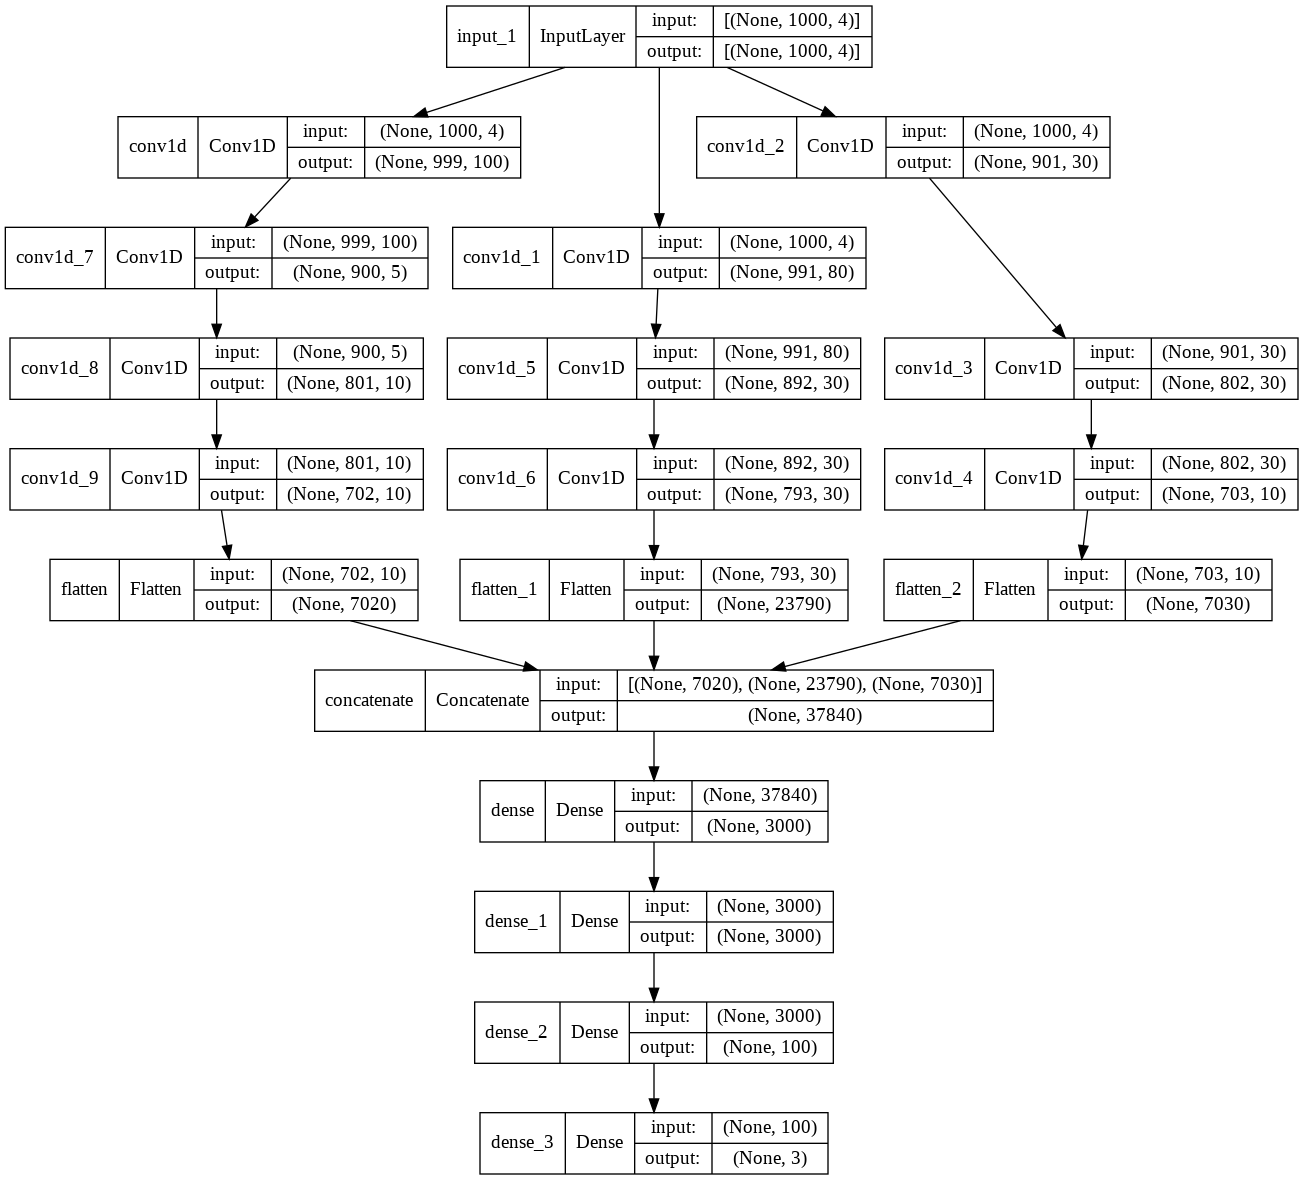

In [ ]:
#@title создание модели , ввод в десятитысячных
def build():
    
    lrelu=keras.layers.LeakyReLU(alpha=0.3)
    iner=keras.initializers.HeUniform()
    reg=keras.regularizers.L2(0.00001)
    input = Input(shape=(1000,4))
#keras.layers.Conv1D(30,100, activation=lrelu, kernel_initializer=iner,kernel_regularizer="l2")(input)

    x1=keras.layers.Conv1D(100,2, activation=lrelu, kernel_initializer=iner,kernel_regularizer=reg)(input)
    x2=keras.layers.Conv1D(80,10, activation=lrelu, kernel_initializer=iner,kernel_regularizer=reg)(input)
    x3=keras.layers.Conv1D(30,100, activation=lrelu, kernel_initializer=iner,kernel_regularizer=reg)(input)

    x3=keras.layers.Conv1D(30,100, activation=lrelu, kernel_initializer=iner,kernel_regularizer=reg)(x3)

    x3=keras.layers.Conv1D(10,100, activation=lrelu, kernel_initializer=iner,kernel_regularizer=reg)(x3)
    x2=keras.layers.Conv1D(30,100, activation=lrelu, kernel_initializer=iner,kernel_regularizer=reg)(x2)
    x2=keras.layers.Conv1D(30,100, activation=lrelu, kernel_initializer=iner,kernel_regularizer=reg)(x2)
    x1=keras.layers.Conv1D(5,100, activation=lrelu, kernel_initializer=iner,kernel_regularizer=reg)(x1)
    x1=keras.layers.Conv1D(10,100, activation=lrelu, kernel_initializer=iner,kernel_regularizer=reg)(x1)
    x1=keras.layers.Conv1D(10,100, activation=lrelu, kernel_initializer=iner,kernel_regularizer=reg)(x1)


    a=keras.layers.Flatten()(x1)
    b=keras.layers.Flatten()(x2)
    c=keras.layers.Flatten()(x3)

    x=keras.layers.Concatenate()([a,b,c])
    x=Dense(3000, activation=lrelu, kernel_initializer=iner,kernel_regularizer=reg)(x)
    x=Dense(3000, activation=lrelu, kernel_initializer=iner,kernel_regularizer=reg)(x)
    x=Dense(100, activation=lrelu, kernel_initializer=iner,kernel_regularizer=reg)(x)
    x=Dense(3, activation="softmax", kernel_initializer=iner,kernel_regularizer=reg)(x)

    model = keras.Model(inputs=input, outputs=x)
    lr=1#@param {type:"integer"}
    lr/=10000

    momentum=1#@param {type:"integer"}
    momentum/=10000

    model.compile(optimizer=keras.optimizers.SGD( learning_rate=lr, momentum=momentum, nesterov=True),loss='categorical_crossentropy',metrics=['accuracy'])

    
    return model

model=build()
show=False#@param {type:"boolean"}
if show:
    print(model.summary())
keras.utils.plot_model(model, "mini_resnet.png", show_shapes=True)

In [ ]:
#@title проверка
def Eva(col,model):
    deu=[0,0,0]
    summ=0
    A=next(gen(col,1000,testCots,0))
    pred=model.predict_on_batch([A[0]])
    for i in range(col):
        Max=pred[i].argmax()
        deu[Max]+=1
        if(  A[1][i][0]==1 and Max==0):
            summ+=50
            continue
        elif(A[1][i][0]==0 and Max==0):
            summ-=30
            continue
        if(  A[1][i][1]==1 and Max==2):
            summ+=50
            continue
        elif(A[1][i][1]==0 and Max==2):
            summ-=30
            continue
        #summ-=1
    return summ,deu

In [ ]:
#@title генератор v2
def gen(batch,col,cots,start=0):
    while True:
        inputs = []
        targets = []
        for i in range(batch):
            start=1+start
            if start==1:
                start=random.randint(10,len(cots)-5000)
            if start >=len(cots)-1000:
                start=0
            
            #if start % 10000==0:
            #print(start)
            
            if float(cots[start+col-1][6]) > 0:
                targets.append([1.0, 0.0, 0.0])
            elif float(cots[start+col-1][7]) > 0:
                targets.append([0.0, 0.0, 1.0])
            else:
                targets.append([0.0, 1.0, 0.0])

            inp=[]

            #higmax = cots[start][3]
            #lowmin = cots[start][3]

            #for k in range(start, start+col):
                #higmax = max(cots[k][3],higmax)
                #lowmin = min(cots[k][3],lowmin)

            #inp.append(cots[start][4])
            #inp.append(higmax/lowmin)

            for k in range(start, start+col):
                inp.append(cots[k][0]-cots[k-1][0])
                inp.append(cots[k][1]-cots[k-1][1])
                inp.append(cots[k][2]-cots[k-1][2])
                inp.append(cots[k][3]-cots[k-1][3])

            inputs.append(inp)
        yield np.reshape( np.array(inputs),[batch,1000,4]),np.array(targets)


In [ ]:
#@title генератор v3
def gen(batchsize, col, cots,start = 0):
    genin = []
    while True:
        inputs = []
        targets = []
        for i in range(0, batchsize):
            inp = []
            inp2=[]
            if start == 0:
                start = random.randint(0, len(cots)-1500)

            m = np.array(cots[start:start+col]).transpose()
            higmax = max(m[1])
            lowmin = min(m[2])
            volmax = max(m[5])
            volmin = min(m[5])
            
            inp2.append(cots[start][4])
            inp2.append(higmax/lowmin)
            
            for k in range(start, start+col):
                inp.append((cots[k][0]-lowmin)/(higmax-lowmin))
                inp.append((cots[k][1]-lowmin)/(higmax-lowmin))
                inp.append((cots[k][2]-lowmin)/(higmax-lowmin))
                inp.append((cots[k][3]-lowmin)/(higmax-lowmin))
                inp.append((cots[k][5]-volmin)/(volmax-volmin))
            inputs.append(inp)
        yield np.reshape( np.array(inputs),[col,5]), np.array(targets)

In [ ]:
#@title создание или очищение массивов с историческими данными 
hloss=[]
hvloss=[]
sum=[]

In [ ]:
next(gen(1,70,trainCots,12800))

In [ ]:
 #@title обучение модели (долгое, останавливается вручную)

while True:
    for i in range(16):
        X,Y=next(gen(12800,1000,trainCots,i*12800))
        his=model.fit(X,Y,shuffle=True,verbose=1,epochs=1)

        s=Eva(1000,model)
        print(s)
        print("текущий выигрыш на тренировочных данных",s[0])
        print(s[1][0],"покупок",s[1][2],"продаж")
        sum+=[s[0]]

        hloss+=his.history['loss']
        plt.plot( hloss, 'g', label='Training loss')
        plt.show()

        plt.plot( sum, 'b', label='sum')
        plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#model.save_weights("/content/drive/MyDrive/projects/P1/model4.h5")

In [ ]:
model.load_weights("/content/drive/MyDrive/projects/P1/model4.h5")

In [ ]:
#@title проверка работоспособности на тестовых данных
summ=0
b=0
dos=0
sdel=[]
act=0.50
col=10 #@param {type:"integer"}
while True:
    b+=1
    if b==col:
        break
    A=next(gen(100,1000,trainCots,0))
    pred=model.predict_on_batch([A[0]])
    for i in range(len(pred)):
        Max=pred[i].argmax()

        if pred[i][Max]>act and not Max==1 :
            print(pred[i],Max)
            if( A[1][i][0]==1 and Max==0):
                summ+=50
                print('b+ ',summ) 
                dos+=1
                sdel+=[summ]
                act=act/1.01
                continue
            elif(A[1][i][0]==0 and Max==0 ):
                summ-=30
                print('b- ',summ) 
                dos+=1
                sdel+=[summ]
                act=act*1.01
                continue
            if(A[1][i][1]==1 and Max==2 ):
                summ+=50
                print('s+ ',summ)
                dos+=1
                sdel+=[summ]
                act=act/1.01
                continue
            elif( A[1][i][1]==0 and Max==2 ):
                summ-=30
                print('s- ',summ)
                dos+=1
                sdel+=[summ]
                act=act*1.01
                continue
        else:
            act=act/1.001
        #print(b,dos,'n  '+('b' if (A[1][i][0]==1) else '')+('s' if (A[1][i][1]==1) else ''),summ,pred[i])
    print('---------------',b,dos,summ,act)

plt.plot( sdel, 'b')
plt.show()

In [ ]:
next(Generator(1,100,lastCots))[0][0]